In [1]:
!pip -q install inltk

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import re
import os
import sentencepiece as spm
import pickle
import pathlib
from fastai.text import *
torch.cuda.set_device(0)

working_path = '/kaggle/working'
input_data_path = '/kaggle/input'

data_paths = {}
for dirname, _, filenames in os.walk(input_data_path):
    for filename in filenames:
        data_paths[filename] = os.path.join(dirname, filename)
        print(os.path.join(dirname, filename))

/kaggle/input/telugu-sentencepiece-tokenizer/TeluguWikiSentences.txt
/kaggle/input/telugu-sentencepiece-tokenizer/custom.css
/kaggle/input/telugu-sentencepiece-tokenizer/__notebook__.ipynb
/kaggle/input/telugu-sentencepiece-tokenizer/telugu_tok.vocab
/kaggle/input/telugu-sentencepiece-tokenizer/telugu_tok.model
/kaggle/input/telugu-sentencepiece-tokenizer/__results__.html
/kaggle/input/telugu-sentencepiece-tokenizer/__output__.json
/kaggle/input/telugu-wikipedia-data/telugu_wikipedia_dataset.parquet
/kaggle/input/telugu-wikipedia-data/telugu_wiki_links.csv
/kaggle/input/telugu-language-model/custom.css
/kaggle/input/telugu-language-model/__notebook__.ipynb
/kaggle/input/telugu-language-model/embedding_vectors.tsv
/kaggle/input/telugu-language-model/export.pkl
/kaggle/input/telugu-language-model/__results__.html
/kaggle/input/telugu-language-model/__output__.json
/kaggle/input/telugu-language-model/telugu_lm.data
/kaggle/input/telugu-language-model/embedding_metadata.tsv
/kaggle/input/t

In [3]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.57', '1.3.0')

In [4]:
data_df = pd.read_parquet(data_paths['telugu_news_dataset.parquet'])
data_df.shape, data_df.columns

((21419, 3), Index(['title', 'text', 'category'], dtype='object'))

In [5]:
data_df['category'].value_counts()

eenadu_sports      5852
eenadu_national    5022
eenadu_business    4273
eenadu_crime       3241
eenadu_cinema      3031
Name: category, dtype: int64

In [6]:
data_df['t'] = (data_df['title'] + ' ' + data_df['text']).tolist()
data_df['t'].str.len().mean(), data_df['t'].str.len().min(), data_df['t'].str.len().max()# in characters

(1180.3481021522946, 41, 14027)

In [7]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data_df, test_size=0.2)
train_df.shape, test_df.shape

((17135, 4), (4284, 4))

In [8]:
sp = spm.SentencePieceProcessor()
sp.Load(data_paths['telugu_tok.model'])
itos = [sp.IdToPiece(int(i)) for i in range(25000)] # 25,000 is the vocab_size selected in sm tokenizer
telugu_vocab = Vocab(itos)

In [9]:
from telugu_tokenizer_class_fastai import TeluguTokenizer
tokenizer = Tokenizer(tok_func=TeluguTokenizer, lang='te')
tokenizer.special_cases

1.0.57


['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep']

In [10]:
data_lm = TextLMDataBunch.from_df(working_path, train_df=train_df, valid_df=test_df,
                                  text_cols=["t"], bs=96,
                                  tokenizer=tokenizer, vocab=telugu_vocab) # default bs=64
data_lm.save('telugu_cls_lm.data')

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CrossEntropyLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [11]:
data_lm.show_batch()

idx,text
0,"▁త్రైమాసిక ▁ఆదాయం ▁కూడా ▁రూ . 18 68 . 79 ▁కోట్ల ▁నుంచి ▁రూ . 2,1 69 . 26 ▁కోట్ల కు ▁పెరిగింది . ▁గత ▁ఆర్థిక ▁సంవత్సరం ▁పూర్తి కాలానికి ▁స్టాండ్ ▁అ లో న్ ▁ఖాతా ల ▁ప్రకారం ▁అపో లో ▁హాస్పిటల్ స్ ▁ఆదాయం ▁రూ . 8 , 34 8. 90 ▁కోట్లు , ▁నికర లా భం ▁రూ . 30 2 . 76 ▁కోట్లు , ▁ఈ పీ ఎస్ ▁రూ . 21 . 76 ▁నమోదయ్య ాయి . ▁అంతకు"
1,"కే సి ▁బోయింగ్ ▁కు ▁375 ▁మిలియన్ ▁డాలర్ల ▁ఆర్డర్ ▁ఇచ్చింది . ▁నాలుగు ▁7 37 - 400 , ▁ఆరు ▁7 37 - 800 ▁విమానాలను ▁కొనుగోలు ▁చేసింది . ▁దాంతో ▁ఏడాది కి ▁24 ▁లక్షల ▁మంది ▁ప్రయాణికుల ్ని ▁గమ్యస్థాన ాలకు ▁చేర్చ గలిగే ▁స్థాయికి ▁ఎదిగింది . ▁అప్పటికి ▁మొత్తం ▁12 ▁బోయింగ్ ▁7 37 ▁విమానాల తో ▁83 ▁రోజువారీ ▁విమాన ▁సర్వీసులు ▁23 ▁గమ్యస్థాన ాలకు ▁నడిప ేవారు . ▁దీంతో ▁20 ▁శాతం ▁మార్కెట్ ▁వాటా ▁ఈ ▁కంపెనీ ▁సొంత మైంది . ▁ <unk>"
2,"▁ఈ ▁శిక్ష ▁విధించారు . ▁శామ్ ▁సంగ్ ▁గ్రూప్ ▁ప్రధాన ▁అనుబంధ ▁సంస్థ ే ▁శామ్ ▁సంగ్ ▁ఎలక్ట్రానిక్స్ ▁ . ▁కుటుంబ ▁యాజమాన్యం లోని ▁ఈ ▁అగ్ర గా మి ▁సంస్థ , ▁ప్రపంచంలోనే ▁దక్షిణ కొ రియా ▁11 వ ▁అతిపెద్ద ▁ఆర్థిక ▁వ్యవస్థ గా ▁అవతరించ ేందుకు ▁కారణమైంది . ▁అయితే ▁కార్మిక ▁చట్టాల ▁విషయంలో ▁ప్రభుత్వం తో ▁సంస్థ ▁పోరాడ ుతూనే ▁వచ్చింది . ▁సంస్థ ▁ప్రధాన ▁కార్యాలయం ▁ఉన్న ▁సు వాన్ ▁లో , ▁నేషనల్ ▁శామ్ ▁సంగ్ ▁ఎలక్ట్రానిక్స్ ▁యూనియన్ ▁ను ▁ఇటీవల ▁స్థానిక ▁అధికారులు ▁ధ్రువీకరించ ారు ."
3,"▁దాఖలు ▁చేసింది . ▁ఆ ఫర్ ▁ఫర్ ▁సే ల్ ▁లో ▁భాగంగా ▁కంపెనీ ▁ఛైర్మన్ ▁ఖుర్ షీ ద్ ▁ దారు వాలా , ▁షా పూర్ ▁జీ ▁పల్ లో ం జీ ▁అండ్ ▁కంపెనీలు ▁వాటా ▁విక్రయించ ను న్నాయి . ▁ <unk> ▁ఆరోగ్య ▁సంరక్షణ ▁సంస్థ ▁బ్రాండ్ ▁మె డ్ ▁లో ▁30 ▁శాతం ▁వాటా ను ▁దక్షిణాఫ్రికా ▁అనుబంధ ▁సంస్థ ▁సి ప్లా ▁మె డ్ ▁ప్రో ▁రూ . 32 ▁కోట్ల కు ▁కొనుగోలు ▁చేయ ను ందని ▁ఔషధ ▁సంస్థ ▁సి ప్లా ▁తెలిపింది . ▁"
4,▁ఫోర్స్ ▁అదనపు ▁డీ సీ పీ ▁పి . రా ధా కి షన్ ▁రావు ▁తెలిపిన ▁వివరాల ▁ప్రకారం . . ▁గుడివాడ కు ▁చెందిన ▁కా ట్ర గడ్డ ▁నర ేశ్ ▁( 35 ) ▁వృత్తి ▁రీత్యా ▁పాల ▁వ్యాపారి . ▁కూ క ట్ ▁పల్లిలో ని ▁భాగ్య నగర్ ▁కాలనీ లో ▁నివాసం ▁ఉంటున్న ాడు . ▁హబ్ సి గూడ ▁రవీంద్ర నగర్ ▁కాలనీ కి ▁చెందిన ▁ఖా సిం ▁మొహ ్ మద్ ▁ర జా ( 44 ) ▁ఏ జీ ఎస్ ▁సెక్యూరిటీ ▁సర్వీసెస్ ▁ఉద్యోగి


In [12]:
len(data_lm.vocab.itos)

25000

In [13]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.25)
learn = learn.to_fp16(clip=0.1)
# Loading the pretrained language model on telugu wikipedia
learn.load(data_paths['fourth.pth'][:-4], with_opt=True)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (17135 items)
x: LMTextList
▁x x bo s ▁రాణించ ిన ▁అపో లో ▁హాస్పిటల్ స్ ▁ఈనాడు , ▁హైదరాబాద్ ▁: ▁అపో లో ▁హాస్పిటల్ స్ ▁ఎంటర్ ▁ప్రైజ్ ▁స్టాండ్ ▁అ లో న్ ▁ఖాతా ల ▁ప్రకారం ▁గత ▁ఆర్థిక ▁సంవత్సరం ▁నాలుగో ▁త్రైమాసిక ంలో ▁రూ . 76 . 68 ▁కోట్ల ▁నికర లా భ ాన్ని ▁నమోదు ▁చేసింది . ▁అంతకు ▁ముందు ▁ఆర్థిక ▁సంవత్సరం ▁ఇదే కాలంలో ▁ఉన్న ▁రూ . 59 . 64 ▁కోట్ల తో ▁పోల్చితే ▁ఇది ▁28 . 57 ▁శాతం ▁అధికం . ▁అదే ▁విధంగా ▁త్రైమాసిక ▁ఆదాయం ▁కూడా ▁రూ . 18 68 . 79 ▁కోట్ల ▁నుంచి ▁రూ . 2,1 69 . 26 ▁కోట్ల కు ▁పెరిగింది . ▁గత ▁ఆర్థిక ▁సంవత్సరం ▁పూర్తి కాలానికి ▁స్టాండ్ ▁అ లో న్ ▁ఖాతా ల ▁ప్రకారం ▁అపో లో ▁హాస్పిటల్ స్ ▁ఆదాయం ▁రూ . 8 , 34 8. 90 ▁కోట్లు , ▁నికర లా భం ▁రూ . 30 2 . 76 ▁కోట్లు , ▁ఈ పీ ఎస్ ▁రూ . 21 . 76 ▁నమోదయ్య ాయి . ▁అంతకు ▁ముందు ▁ఆర్థిక ▁సంవత్సరంలో ▁ఆదాయం ▁రూ . 7 , 19 5. 60 ▁కోట్లు , ▁నికర లా భం ▁రూ . 23 3. 20 ▁కోట్లు , ▁ఈ పీ ఎస్ ▁రూ . 16 . 76 ▁ఉన్నాయి . ▁సంస్థ ▁నమోదు ▁చేసిన ▁ఆర్థిక ▁ఫలితాల పై ▁ఛైర్మన్ ▁ప్రతాప్ ▁సి . రెడ్డి ▁సంతృప్తి ▁వ్యక్తం ▁చేశారు . ▁ఆరో

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


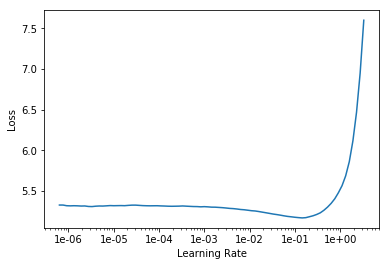

In [14]:
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.freeze()
learn.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))
learn.save('fit_head', with_opt=True)

epoch,train_loss,valid_loss,accuracy,time
0,4.202055,4.042468,0.328269,02:02
1,3.937114,3.889611,0.346589,02:01


In [16]:
learn.load('fit_head', with_opt=True);

In [17]:
learn.unfreeze()
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))
learn.save('first_lm', with_opt=True)

epoch,train_loss,valid_loss,accuracy,time
0,3.727552,3.768505,0.361150,02:28
1,3.656833,3.667644,0.374679,02:28
2,3.392469,3.512491,0.395109,02:28
3,3.046105,3.404310,0.411150,02:28
4,2.738274,3.413035,0.413405,02:28


In [18]:
learn.fit_one_cycle(7, 1e-3, moms=(0.8,0.7))
learn.save('fine_tuned', with_opt=True)
learn.save_encoder('fine_tuned_encoder')

epoch,train_loss,valid_loss,accuracy,time
0,2.702590,3.422511,0.413316,02:28
1,2.716725,3.417600,0.413531,02:28
2,2.688772,3.421535,0.413924,02:28
3,2.629656,3.429466,0.414402,02:28
4,2.553763,3.438818,0.414528,02:28
5,2.506195,3.447296,0.414193,02:28


In [19]:
data_clas = TextClasDataBunch.from_df(working_path, train_df=train_df, valid_df=test_df,
                                  text_cols=["t"], label_cols = ['category'], bs=96,
                                  tokenizer=tokenizer, vocab=telugu_vocab)

In [20]:
data_clas.show_batch()

text,target
▁x x bo s ▁మనం ▁అ జేయ ుల ం ▁ఎదురు లేని ▁టీ మ్ ▁ఇండియా ▁పాక్ ▁పై ▁కొనసాగిన ▁జై త్ర యాత్ర ▁రో హి త్ ▁సూపర్ ▁సెంచరీ ▁మాయ ▁చేసిన ▁కు ల్ ▁ దీప్ ▁4 ▁మార్చి ▁1992 . . ▁9 ▁మార్చి ▁1996 . . ▁8 ▁జూన్ ▁1999 . . ▁1 ▁మార్చి ▁2003 . . ▁30 ▁మార్చి ▁2011 . . ▁15 ▁ఫిబ్రవరి ▁2015 . . ▁భారత ▁క్రికెట్ ▁అభిమానుల ▁హృదయ ాలు ▁ఉప్ప ొ ంగ ేలా,eenadu_sports
▁x x bo s ▁మన ▁మంచి ▁గులాబి ▁తొలి ▁డే ▁/ ▁నైట్ ▁టెస్టు లో ▁భారత్ ▁జో రు ▁ఫాస్ట్ ▁బౌలర్ ల ▁జాతర . . ▁పది కి ▁పది ▁వికెట్లు ▁30 . 3 ▁ఓవర్ లలో ▁106 ▁పరుగుల కే ▁బంగ్లా ▁ఆ ల ౌట్ ▁తొలి ▁ఇన్నింగ్స్ ▁లో ▁టీ మ్ ▁ఇండియా ▁174 ▁/ ▁3 ▁నిండు గా ▁స్టేడియం . . ▁ఒకటే ▁కే ర ింతలు . . ▁అక్కడ ▁ఐ పీ ఎల్ ▁మ్యాచ్ ▁ఏమైనా ▁జరుగు తో ందా ▁అనిపించ ే ▁సందడి,eenadu_sports
"▁x x bo s ▁ ఛే దం చేశారు ▁కో హ్ లి ▁కెప్టెన్ ▁ఇన్నింగ్స్ ▁రాణించ ిన ▁రాహుల్ ▁ , ▁రో హి త్ ▁శా ర్ దూ ల్ ▁ , ▁జ డే జా ▁కొస ▁మెరుపు లు ▁మూడో ▁వన్డే ▁భారత్ ▁దే ▁సూపర్ ▁ఫా మ్ ▁లో ▁ఉన్న ▁రో హి త్ ▁మళ్లీ ▁మెరి శాడు . ▁జో రు ▁కొనసాగిస్తూ ▁రాహుల్ ▁మరో ▁విలువైన ▁ఇన్నింగ్స్ ▁ఆడాడు . ▁కెప్టెన్ ▁కో హ్ లి ▁ఇన్నింగ్స్ ▁కు ▁వెన్నెముక లా ▁నిలిచి , ▁ఇబ్బందుల ్లో",eenadu_sports
"▁x x bo s ▁సీతమ్మ ▁వర ాలు ▁ఆర్థిక ▁మంద గమనం . . ▁ప్రభుత్వ ▁ఉపశమనం . . ▁అధిక ▁సంపన్న ▁వర్గాల పై ▁సర్ ▁ఛార్ జీ ▁ఉప సం హరణ ▁వాహన ▁రంగ ానికీ ▁ఊత ం ▁బ్యాంకు లు , ▁ఎన్ ▁బీ ఎఫ్ ▁సీ లకూ ▁మద్దతు ▁అంకుర ాలకు ▁పన్ను ▁కష్టాలు ▁దూరం ▁రె పో రేటు కు ▁గృహ , ▁వాహన ▁వడ్డీ ▁రే ట్ల ▁అనుసంధానం ▁ఎం ఎస్ ▁ఎమ్ ▁ఈ లకు ▁60 ▁రోజుల్లో నే ▁జీ ఎస్ ▁టీ ▁రి ఫ ండ్",eenadu_business
"▁x x bo s ▁మనం ▁మారి పో యాం . . . ▁తెలుస ా . . !! ▁మనం ▁మారి పో యాం . . ▁తెలుస ా . . . !! ▁అవు న ండీ ▁మనం ▁మారి పో యాం . . . ▁చాలా ▁చాలా . . ▁స్ మార్ ట్ ▁ఫోన్ ▁వచ్చే సింది . . . ▁మన ▁ప్రపంచ ాన్ని ▁చిన్నది ▁చేసే సింది . ▁అమెజాన్ ▁ప్రై మ్ ▁లో నో , ▁నెట్ ▁ఫ్ల ి క్స్ ▁లో నో",eenadu_business


In [21]:
data_clas.sanity_check()


In [22]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

In [23]:
learn.load_encoder('fine_tuned_encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (17135 items)
x: TextList
▁x x bo s ▁రాణించ ిన ▁అపో లో ▁హాస్పిటల్ స్ ▁ఈనాడు , ▁హైదరాబాద్ ▁: ▁అపో లో ▁హాస్పిటల్ స్ ▁ఎంటర్ ▁ప్రైజ్ ▁స్టాండ్ ▁అ లో న్ ▁ఖాతా ల ▁ప్రకారం ▁గత ▁ఆర్థిక ▁సంవత్సరం ▁నాలుగో ▁త్రైమాసిక ంలో ▁రూ . 76 . 68 ▁కోట్ల ▁నికర లా భ ాన్ని ▁నమోదు ▁చేసింది . ▁అంతకు ▁ముందు ▁ఆర్థిక ▁సంవత్సరం ▁ఇదే కాలంలో ▁ఉన్న ▁రూ . 59 . 64 ▁కోట్ల తో ▁పోల్చితే ▁ఇది ▁28 . 57 ▁శాతం ▁అధికం . ▁అదే ▁విధంగా ▁త్రైమాసిక ▁ఆదాయం ▁కూడా ▁రూ . 18 68 . 79 ▁కోట్ల ▁నుంచి ▁రూ . 2,1 69 . 26 ▁కోట్ల కు ▁పెరిగింది . ▁గత ▁ఆర్థిక ▁సంవత్సరం ▁పూర్తి కాలానికి ▁స్టాండ్ ▁అ లో న్ ▁ఖాతా ల ▁ప్రకారం ▁అపో లో ▁హాస్పిటల్ స్ ▁ఆదాయం ▁రూ . 8 , 34 8. 90 ▁కోట్లు , ▁నికర లా భం ▁రూ . 30 2 . 76 ▁కోట్లు , ▁ఈ పీ ఎస్ ▁రూ . 21 . 76 ▁నమోదయ్య ాయి . ▁అంతకు ▁ముందు ▁ఆర్థిక ▁సంవత్సరంలో ▁ఆదాయం ▁రూ . 7 , 19 5. 60 ▁కోట్లు , ▁నికర లా భం ▁రూ . 23 3. 20 ▁కోట్లు , ▁ఈ పీ ఎస్ ▁రూ . 16 . 76 ▁ఉన్నాయి . ▁సంస్థ ▁నమోదు ▁చేసిన ▁ఆర్థిక ▁ఫలితాల పై ▁ఛైర్మన్ ▁ప్రతాప్ ▁సి . రెడ్డి ▁సంతృప్తి ▁వ్యక్తం ▁చేశారు . ▁ఆరోగ్య ▁

In [24]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


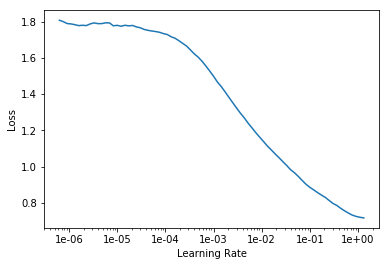

In [25]:
learn.lr_find()
learn.recorder.plot()

In [26]:
kappa = KappaScore()
learn.metrics = [kappa, accuracy]

In [27]:
learn.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))
learn.save('first_cls', with_opt=True)

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.225198,0.161065,0.927347,0.943044,01:03
1,0.174908,0.130818,0.942664,0.954949,01:09


In [28]:
learn.load('first_cls', with_opt=True);

In [29]:
learn.freeze_to(-4)
learn.fit_one_cycle(5, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,kappa_score,accuracy,time


RuntimeError: CUDA out of memory. Tried to allocate 196.00 MiB (GPU 0; 15.90 GiB total capacity; 15.02 GiB already allocated; 51.88 MiB free; 144.04 MiB cached)

In [30]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-2), moms=(0.8,0.7))

RuntimeError: you can only change requires_grad flags of leaf variables. If you want to use a computed variable in a subgraph that doesn't require differentiation use var_no_grad = var.detach().

In [31]:
learn.save('final_cls')

In [32]:
TEXT = "వెల్లింగ్టన్‌: న్యూజిలాండ్‌తో జరిగిన నాల్గో టీ20లో టీమిండియా మరో చిరస్మరణీయమైన విజయాన్ని సాధించింది. అచ్చం మూడో టీ20ని తలపించే విధంగా సూపర్‌ ఓవర్‌కు దారి తీసిన మ్యాచ్‌లో టీమిండియా ఇంకా బంతి ఉండగానే గెలుపును అందుకుంది. సూపర్‌ ఓవర్‌లో న్యూజిలాండ్‌ 14 పరుగుల టార్గెట్‌ను నిర్దేశించగా, దాన్ని టీమిండియా సునాయాసంగా ఛేదించింది. న్యూజిలాండ్‌ సూపర్‌ ఓవర్‌ను సీఫెర్ట్‌-మున్రోలు ఆరంభించారు. కాగా, టీమిండియా ఓవర్‌ను బమ్రా అందుకున్నాడు. తొలి బంతికి సీఫెర్ట్‌ రెండు పరుగులు తీయగా, రెండో బంతికి ఫోర్‌ కొట్టాడు. మూడో బంతికి సీఫెర్ట్‌ రెండు పరుగులు తీయగా, నాల్గో బంతికి ఔటయ్యాడు. ఐదో బంతికి మున్రో ఫోర్‌ కొట్టగా, ఆరో బంతికి సింగిల్‌ తీశాడు."
learn.predict(TEXT)

(Category eenadu_sports,
 tensor(4),
 tensor([3.3998e-06, 5.2534e-05, 8.3377e-06, 2.4360e-05, 9.9991e-01]))

In [33]:
TEXT = 'ఇండోనేషియా ప్రభుత్వం బంపర్‌ ఆఫర్‌ను ప్రకటించింది. ఓ మొసలి మెడలో ఇరుక్కున్న టైర్‌ను తీసిన సాహసవంతులకు భారీ మొత్తంలో నగదు బహుమతి ఇవ్వనున్నట్లు వెల్లడించింది. అయితే ఇందుకోసం వారు 13 అడుగుల మొసలికి ఎదురు వెళ్లాల్సి ఉంటుందని పేర్కొంది. కాగా ఇండోనేషియా సెంట్రల్‌ సులవేసిలోని ఉప్పునీటి సరస్సులో నివసిస్తున్న ఈ మొసలి మెడకు మోటర్‌ సైకిల్‌ టైర్‌ ఇరుక్కుంది. రోజు రోజుకు ఆ టైరు మొసలి మెడ నుంచి పొట్టమీదకు జారుతూ బిగుసుకుపోతోంది. కాగా టైరు వల్ల ఇబ్బంది పడుతున్నమొసలి ప్రాణాలకు ప్రమాదం ఉందని గ్రహించిన అధికారులు దానిని తీయడానికి ఈ భారీ ఆఫర్‌ను ప్రకటించారు. అయితే ఆ ఆఫర్‌కు ఆకర్షితులైన కొంత మంది ఈ సాహసానికి పూనుకుని ముందుకు వచ్చారు. ఆ టైర్‌ను తీసేందుకు సరస్సులోకి దిగిన వారు మొసలిని ఎదుర్కొలేక వెనుతిరుగుతున్నారు. ఇందుకు సంబంధించిన వీడియో ప్రస్తుతం సోషల్‌ మీడియాలో వైరల్‌ అవుతుంది'
learn.predict(TEXT)

(Category eenadu_national,
 tensor(3),
 tensor([0.0052, 0.0010, 0.0974, 0.8858, 0.0106]))

In [34]:
### 